In [247]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy.stats import chi2_contingency 

In [248]:
data_path = "../data/A2Q2.csv"
columns = ['T_healty', 'T_covid', 'RR_healty', 'RR_covid']

In [249]:
dataset = pd.read_csv(data_path, header=None)
dataset.columns = columns # set the headers
dataset.tail()


,T_healty,T_covid,RR_healty,RR_covid
195,36.763476,38.346639,21.411512,13.412643
196,36.667546,38.888879,21.448498,29.994089
197,37.086574,40.840871,14.076885,16.577924
198,36.805991,41.391529,23.704915,12.518396
199,37.058845,37.703695,23.900662,16.001530


# Q1

In [250]:
# Create dataframe for Q1
healthy_patients_df = pd.DataFrame()

# create a Temp Category
healthy_patients_df['T_cat'] = dataset['T_healty'].apply(
    lambda temp: "t-normal" if temp <= 36.8 else "t-fever",
    )

# Create a Resperation Category
healthy_patients_df['RR_ord'] = dataset['RR_healty'].apply(
    lambda rr: "RR-low" if rr < 19.0 else "RR-med" if rr < 23.0 else "RR-high"
    )

healthy_patients_df.head()

,T_cat,RR_ord
0,t-normal,RR-high
1,t-fever,RR-low
2,t-normal,RR-high
3,t-fever,RR-high
4,t-fever,RR-med


In [251]:
# Create a Contengency Table
contangency_table_df = healthy_patients_df[['T_cat', 'RR_ord']].value_counts().reset_index().pivot(index='T_cat', columns='RR_ord', values='count')
contangency_table_df

RR_ord,RR-high,RR-low,RR-med
T_cat,,,
t-fever,30,33,31
t-normal,35,26,45


In [252]:
# Create the Expected Frequency Table:
temp_totals = dict(contangency_table_df.sum(axis=1))
rr_totals = dict(contangency_table_df.sum(axis=0))
total = sum(temp_totals.values())

assert total == sum(rr_totals.values()), f"Totals are not correct" 

rr_exp = {}
for rr in rr_totals:
    t_exp = {}
    for t in temp_totals:
        freq_exp = temp_totals[t] * rr_totals[rr] / total
        t_exp[t] = freq_exp
    rr_exp[rr] = t_exp

exp_frequencies_df = pd.DataFrame(rr_exp)
exp_frequencies_df

,RR-high,RR-low,RR-med
t-fever,30.55,27.73,35.72
t-normal,34.45,31.27,40.28


In [253]:
# Chi Square test
chi_square = (((contangency_table_df - exp_frequencies_df)**2) / exp_frequencies_df).sum().sum()
chi_square

3.085177867937282

In [254]:
# validation 
statistic, pvalue, dof, exp_f = chi2_contingency(contangency_table_df.values)

print(f"Chi-Square Value = {statistic}")
print(f"p-value = {pvalue}")
print(f"Degree of Freedom = {dof}")
print(f"Expected Frequencies = {exp_f}")

Chi-Square Value = 3.085177867937282
p-value = 0.2138268007447951
Degree of Freedom = 2
Expected Frequencies = [[30.55 27.73 35.72]
 [34.45 31.27 40.28]]


do not reject null hypothess for significance level 0.05

# Q2

In [255]:
iqr = dataset["T_healty"].describe()["75%"] - dataset["T_healty"].describe()["25%"]
trimed_t_heathy = dataset["T_healty"].sort_values().reset_index().iloc[10:190]
trimmed_iqr = trimed_t_heathy["T_healty"].describe()["75%"] - trimed_t_heathy["T_healty"].describe()["25%"]

mean_trimed = trimed_t_heathy["T_healty"].mean()
real_mean = dataset["T_healty"].describe()["mean"]


print(f"Inter Quyartile Range: {iqr}")
print(f"Real mean: {real_mean}")
print(f"Trimmed 10% Inter Quyartile Range: {trimmed_iqr}")
print(f"Trimmed 10% mean: {mean_trimed}")


Inter Quyartile Range: 0.36293975000000245
Real mean: 36.78693378
Trimmed 10% Inter Quyartile Range: 0.31588550000000026
Trimmed 10% mean: 36.78637105


<Axes: title={'center': 'T_healty Boxplots'}, xlabel='Temperature'>

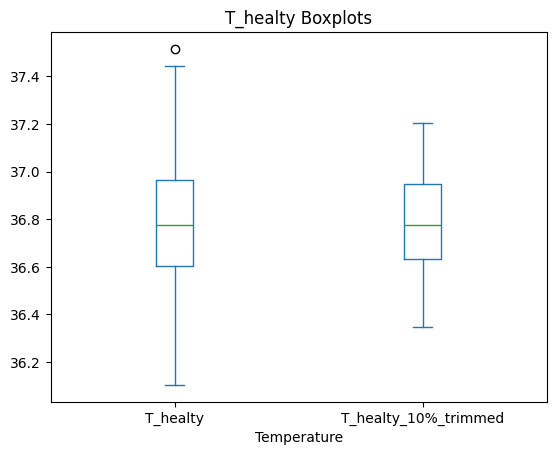

In [256]:
t_cat_df = pd.concat([dataset["T_healty"],trimed_t_heathy[["T_healty"]]],axis=1)
t_cat_df.columns = ["T_healty", "T_healty_10%_trimmed"]
t_cat_df.plot.box(
    xlabel="Temperature",
    title="T_healty Boxplots"
)

In [257]:
t_healthy_list = dataset["T_healty"].values.tolist() # geta list of data
t_healthy_list.sort() # sort the data

len_t_health = len(t_healthy_list) # get the length of data
len_of_quartile = int(math.floor(len_t_health/4)) # get quartile size
quartiles = [
    t_healthy_list[len_of_quartile * quartile: len_of_quartile * (quartile + 1)]
    for quartile in range(4)
]

# print Quartile Ranges
for index, quartile in enumerate(quartiles):
    print(f"Quartile {index+1}: Start({quartile[0]}) End({quartile[-1]})")

Quartile 1: Start(36.104046) End(36.60181)
Quartile 2: Start(36.602745) End(36.775505)
Quartile 3: Start(36.778291) End(36.964375)
Quartile 4: Start(36.968679) End(37.516024)


In [258]:
# verification
dataset["T_healty"].describe()

count    200.000000
mean      36.786934
std        0.264226
min       36.104046
25%       36.602511
50%       36.776898
75%       36.965451
max       37.516024
Name: T_healty, dtype: float64

<Axes: ylabel='Frequency'>

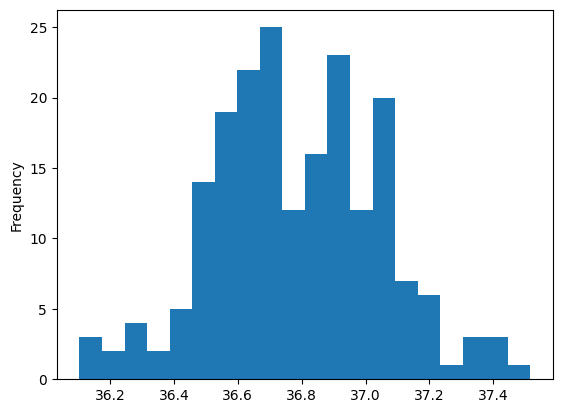

In [259]:
dataset["T_healty"].plot.hist(bins=20)

In [260]:
min_cutoff_index = int(math.floor(len_t_health * 0.05))
max_cutoff_index = len_t_health - min_cutoff_index
t_healthy_list_10_trimmed = t_healthy_list[min_cutoff_index:max_cutoff_index]
sum(t_healthy_list_10_trimmed)/len(t_healthy_list_10_trimmed)

36.786371049999985

# Q3

In [261]:
# init
K = 200000
bootstrap_means = []
t_healthy = dataset['T_healty'].values
real_mean = t_healthy.mean()
len_t_health = len(t_healthy)
lower_10_bound  = int(math.floor(len_t_health*0.05))
upper_10_bound = len_t_health - lower_10_bound
K_lower_confidence_bound = int(math.floor(K*0.05))
K_upper_confidence_bound = K - K_lower_confidence_bound

# Run Bootstrapping  
for _ in range(K):
    # get bootstrap samples with replacement
    bootstrap_sample = np.random.choice(
        t_healthy, 
        size=len_t_health,
        replace= True)

    # get 10% trimmed mean
    trimmed_mean = bootstrap_sample[lower_10_bound:upper_10_bound].mean()

    # add sampled mean
    bootstrap_means.append(trimmed_mean)


# sort the data 
bootstrap_means.sort()

# calculate the confidence intervals 
lower_confidence_interval = bootstrap_means[K_lower_confidence_bound]
upper_confidence_interval = bootstrap_means[K_upper_confidence_bound]



print(f"Lower confidence interval: {lower_confidence_interval}")
print(f"Upper confidence interval: {upper_confidence_interval}")
print(f"------------------------------------------------------")
print(f"actual mean: {real_mean}")

Lower confidence interval: 36.754800288888894
Upper confidence interval: 36.81921059444444
------------------------------------------------------
actual mean: 36.78693378


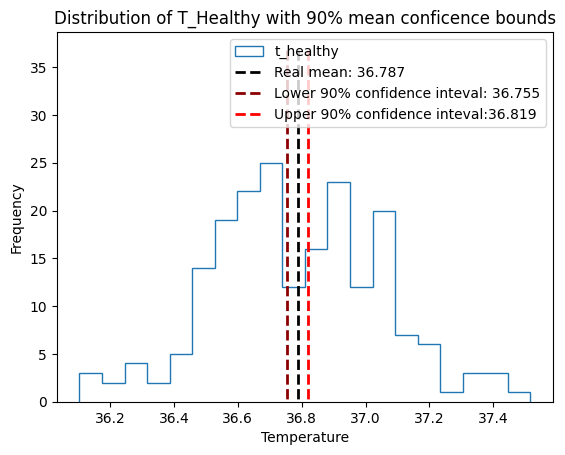

In [262]:
ax = dataset['T_healty'].plot.hist(
    bins=20,
    histtype=u'step',
    label="t_healthy",
    title="Distribution of T_Healthy with 90% mean conficence bounds",
    xlabel="Temperature"
)

plt.plot([real_mean, real_mean], [real_mean, 0], color='black', lw=2, linestyle='--', label=f'Real mean: {real_mean:.3f}')
plt.plot([lower_confidence_interval, lower_confidence_interval], [lower_confidence_interval, 0], color='darkred', lw=2, linestyle='--', label=f'Lower 90% confidence inteval: {lower_confidence_interval:.3f}')
plt.plot([upper_confidence_interval, upper_confidence_interval], [upper_confidence_interval, 0], color='red', lw=2, linestyle='--', label=f'Upper 90% confidence inteval:{upper_confidence_interval:.3f}')
plt.legend(loc='upper right')

# Q4

In [263]:
# build combined features
RR_combined = pd.DataFrame()
RR_combined["RR_combined"] = pd.concat(
    [dataset["RR_covid"], dataset["RR_healty"]],
    axis=0)

# get dataset stats
stats = RR_combined.describe()
min_val = stats.loc['min'].values[0]
max_val = stats.loc['max'].values[0]
q3 = stats.loc['75%'].values[0]
q1 = stats.loc['25%'].values[0]
iqr = q3 - q1
upper_wisker_limit = q3 + (iqr * 1.5)
lower_wisker_limit = q1 - (iqr * 1.5)

print(f"""min: {min_val:0.4f} --- lower_limit: {lower_wisker_limit:.4f} ==> {"no outliers" if min_val > lower_wisker_limit else "outliers exists"}""" )
print(f"""max: {max_val:0.4f} --- upper_limit: {upper_wisker_limit:.4f} ==> {"no outliers" if max_val < upper_wisker_limit else "outliers exists"}""" )

min: 6.3596 --- lower_limit: 0.5403 ==> no outliers
max: 33.1905 --- upper_limit: 41.7433 ==> no outliers


<Axes: title={'center': 'Box Plot for RR_combined'}, ylabel='Respiration Rate'>

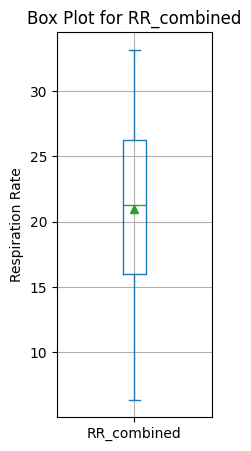

In [264]:
RR_combined.plot.box(
    ylabel="Respiration Rate",
    title="Box Plot for RR_combined",
    figsize=(2,5),
    showmeans=True, 
    grid=True,
    legend=True
)

<Axes: title={'center': 'Histogram with Bin Count = 30'}, xlabel='Respiration Rate', ylabel='Frequency'>

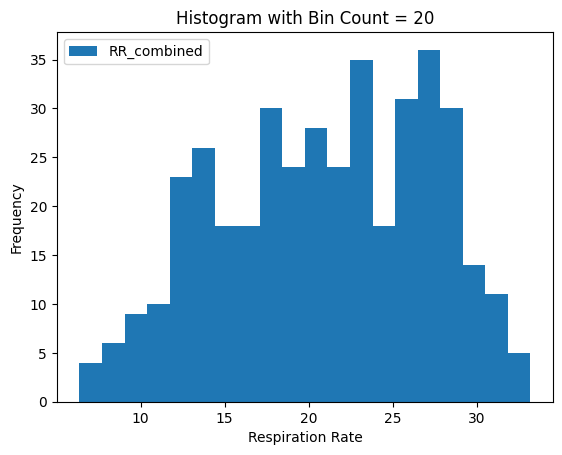

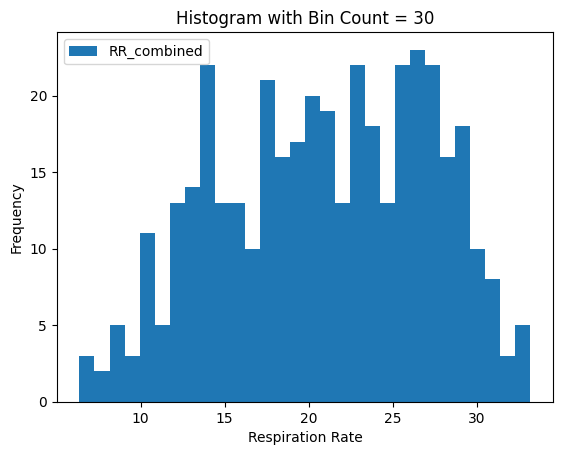

In [265]:
RR_combined.plot.hist(
    bins=20,
    xlabel="Respiration Rate",
    title="Histogram with Bin Count = 20"
)

RR_combined.plot.hist(
    bins=30,
    xlabel="Respiration Rate",
    title="Histogram with Bin Count = 30"
)

# Q5

In [266]:
# init
significance_level_p_val = 0.05
num_permutations = 100000
permuation_mean_diff_samples = []
rr_covid = dataset["RR_covid"].values
rr_healthy = dataset["RR_healty"].values
rr_covid_count = len(rr_covid)
rr_healthy_count = len(rr_healthy)


# calculate observed mean
rr_covid_mean = rr_covid.mean()
rr_healthy_mean = rr_healthy.mean()
real_mean_diff = rr_covid_mean - rr_healthy_mean


# Concatenate data 
rr_conbined = np.concatenate([rr_covid, rr_healthy])

# Run Permuation
for _ in range(num_permutations):
    # shuffle data 
    np.random.shuffle(rr_conbined)

    # sample the data without replacements
    sampled_rr_covid = rr_conbined[:rr_covid_count]
    sampled_rr_healthy = rr_conbined[rr_covid_count:]

    # Calcuate test statstatics
    sampled_rr_covid_mean = sampled_rr_covid.mean()
    sampled_rr_healthy_mean = sampled_rr_healthy.mean()
    sampled_mean_diffrence = sampled_rr_covid_mean - rr_healthy_mean

    # add the observation
    permuation_mean_diff_samples.append(sampled_mean_diffrence)

# calculate p-value
p_val = sum([sample >= real_mean_diff for sample in permuation_mean_diff_samples])/num_permutations

print(f"Observed mean diffrenc: {real_mean_diff}")
print(f"P-value: {p_val}")

# Conclusion
if p_val < significance_level_p_val:  
    print("Significant evidence exists that there is a greater deiffrence in mean for RR_covid and RR_healthy")
else:
    print("Significant evidence DOES NOT exists that there is a greater deiffrence in mean for RR_covid and RR_healthy")


Observed mean diffrenc: -0.08615704999999707
P-value: 0.55621
Significant evidence DOES NOT exists that there is a greater deiffrence in mean for RR_covid and RR_healthy


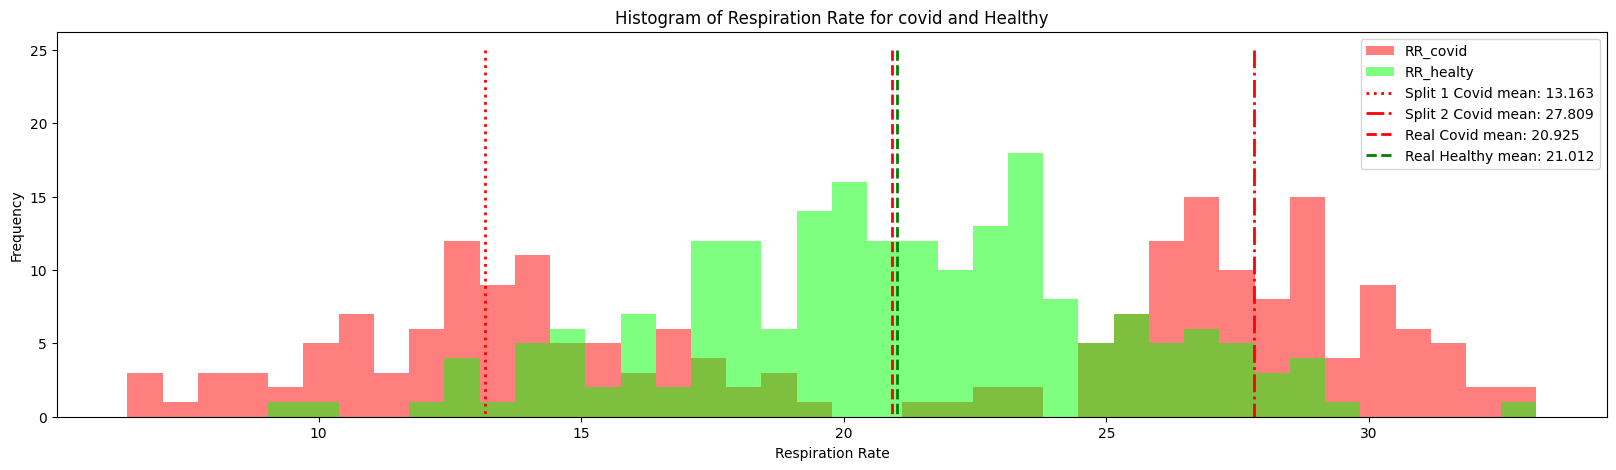

In [267]:
dataset[["RR_covid","RR_healty"]].plot.hist(
    bins=40,
    color=[(1,0,0,0.5),(0,1,0,0.5)],
    title="Histogram of Respiration Rate for covid and Healthy",
    xlabel="Respiration Rate",
    figsize=(20,5)
)

covid_1_mean = dataset[dataset["RR_covid"] < 20]["RR_covid"].mean()
covid_2_mean = dataset[dataset["RR_covid"] > 20]["RR_covid"].mean()

real_covid_mean = dataset["RR_covid"].mean()
real_healthy_mean = dataset["RR_healty"].mean()

plt.plot([covid_1_mean, covid_1_mean], [25, 0], color='red', lw=2, linestyle=':', label=f'Split 1 Covid mean: {covid_1_mean:.3f}')
plt.plot([covid_2_mean, covid_2_mean], [25, 0], color='red', lw=2, linestyle='-.', label=f'Split 2 Covid mean: {covid_2_mean:.3f}')
plt.plot([real_covid_mean, real_covid_mean], [25, 0], color='red', lw=2, linestyle='--', label=f'Real Covid mean: {real_covid_mean:.3f}')
plt.plot([real_healthy_mean, real_healthy_mean], [25, 0], color='green', lw=2, linestyle='--', label=f'Real Healthy mean: {real_healthy_mean:.3f}')
plt.legend(loc='upper right')

# Q6

<Axes: title={'center': 'Temperature Class Distribution'}, xlabel='Temperature', ylabel='Frequency'>

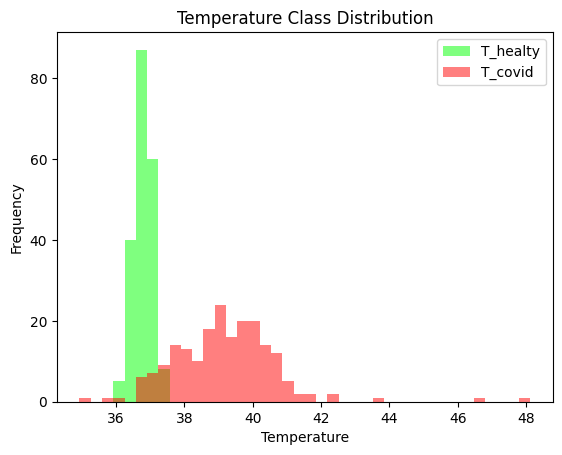

In [268]:
# Plot distributions
dataset[['T_healty', 'T_covid']].plot.hist(
    bins=40,
    color=[(0,1,0,0.5),(1,0,0,0.5)],
    xlabel="Temperature",
    title="Temperature Class Distribution"
)

In [269]:
# lable covid class
temp_1_df = pd.DataFrame()
temp_1_df["temp"] = dataset['T_covid']
temp_1_df["class"] = 1
# lable healthy class
temp_0_df = pd.DataFrame()
temp_0_df["temp"] = dataset['T_healty']
temp_0_df["class"] = 0
# get dataset
temp_df = pd.concat([temp_1_df, temp_0_df])
temp_df

,temp,class
0,40.066609,1
1,38.238644,1
2,38.703265,1
3,39.153882,1
4,37.712948,1
...,...,...
195,36.763476,0
196,36.667546,0
197,37.086574,0
198,36.805991,0


In [282]:
((temp_df - temp_df.min())/(temp_df.max()-temp_df.min()))["temp"]

0      0.389353
1      0.250890
2      0.286084
3      0.320217
4      0.211070
         ...   
195    0.139150
196    0.131884
197    0.163624
198    0.142371
199    0.161524
Name: temp, Length: 400, dtype: float64

<Axes: xlabel='normalized_temperature', ylabel='class'>

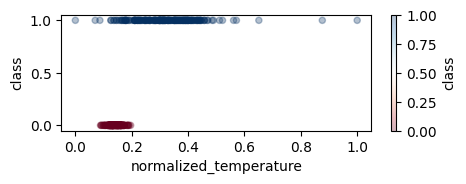

In [313]:
scatter_df = pd.DataFrame()
scatter_df["normalized_temperature"] = ((temp_df - temp_df.min())/(temp_df.max()-temp_df.min()))["temp"]
scatter_df["temperature"] = temp_df["temp"]
scatter_df["class"] = temp_df["class"]
scatter_df.plot.scatter(
    # columns=["temperature"]
    y=2,
    x="normalized_temperature",
    c="class",
    alpha=0.3,
    cmap="RdBu",
    figsize=(5,1.5)
)

In [ ]:
# split the data for test train 
X_train, X_test, y_train, y_test = train_test_split(temp_df["temp"].values, temp_df["class"].values, test_size=0.02, random_state=42)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [ ]:
# train model 
lrc = LogisticRegression(random_state=0).fit(X_train, y_train)

svm = SVC(random_state=0).fit(X_train, y_train)

In [ ]:
y_stand = ((X_train - X_train.mean()) / (X_train.std()))
y_norm = ((X_train - X_train.min()) / (X_train.max() - X_train.min()))

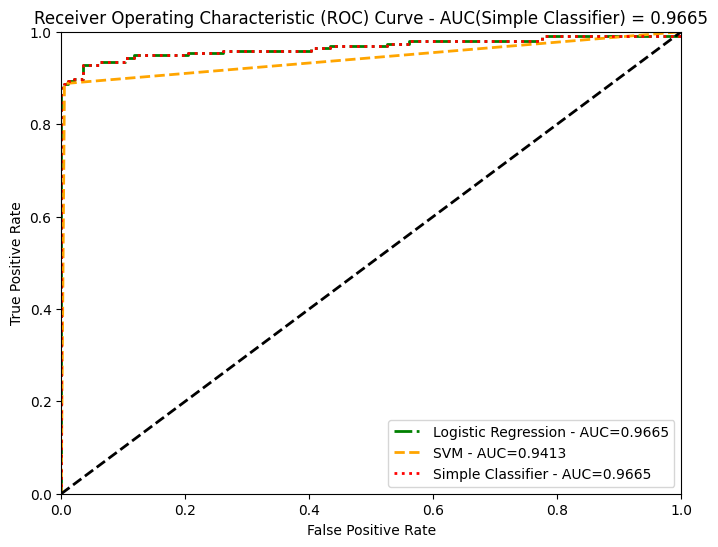

In [ ]:
y_lrc = lrc.predict_proba(X_train)[:, 1]
y_svm = svm.predict(X_train)

fpr_lrc, tpr_lrc, _ = roc_curve(y_train, y_lrc)
roc_auc_lrc = auc(fpr_lrc, tpr_lrc)

fpr_svm, tpr_svm, _ = roc_curve(y_train, y_svm )
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_norm, tpr_norm, _ = roc_curve(y_train, y_norm )
roc_auc = auc(fpr_norm, tpr_norm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lrc, tpr_lrc, color='green', lw=2, linestyle='-.', label=f'Logistic Regression - AUC={roc_auc_lrc:.4f}')
plt.plot(fpr_svm, tpr_svm, color='orange',  lw=2, linestyle='--', label=f'SVM - AUC={roc_auc_svm:.4f}')
plt.plot(fpr_norm, tpr_norm, color='red',  lw=2, linestyle=':', label=f'Simple Classifier - AUC={roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve - AUC(Simple Classifier) = {roc_auc:.4f}')
plt.legend(loc='lower right')
plt.show()